# Inferring the history of gene copy number evolution

In [1]:
from ADG_Complete import *
from IPython.display import Image, display

## Introduction

The general question is the following: Given a present day sample of individuals with different number of gene copies. What is the genealogy of the different copies? How many gene duplications occured? What is the gene duplication rate? What kind of gene copy evolution do we expect under neutrality?

For example: Consider three individuals with (3,2,2) copies. These copies could for example originate from either 4 independent recent duplication events, or one ancient and one recent duplication event.

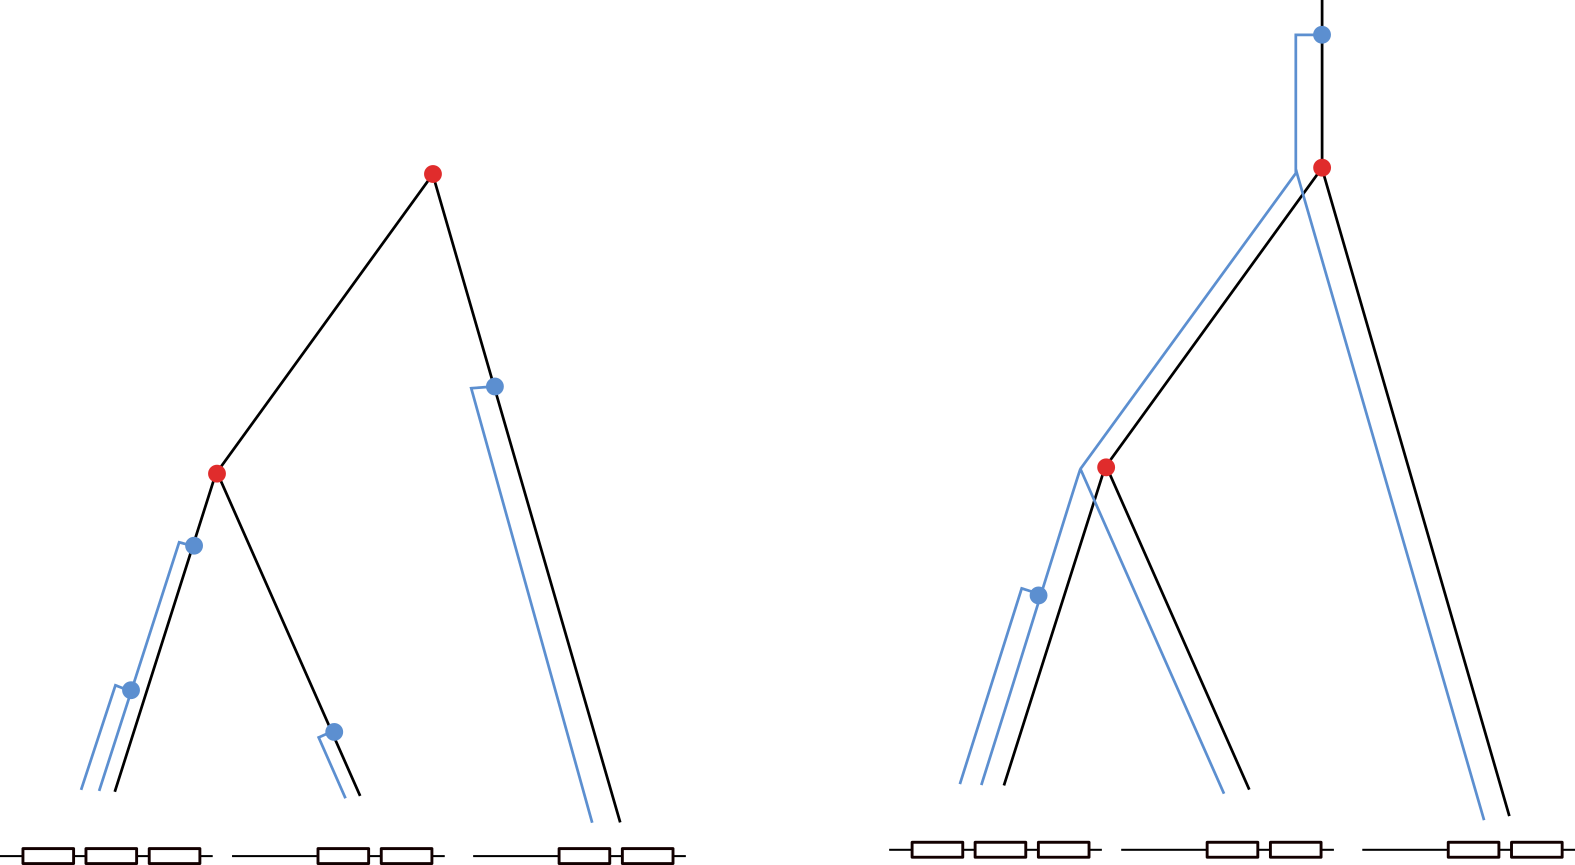

In [2]:
display(Image("ADG_Tree.png", width=800))

## Random Walk on CDN

Consider a given present day copy number configuration. Trace the "path" of the gene copy number distribution $\alpha$, where $\alpha_i$ determines the number of individuals carrying $i$ many copies. With rate $c =1/N$ a split event happens, such that $$\alpha \rightarrow \alpha + 1[i].$$ With rate $d$, a copy duplicates, such that $$\alpha \rightarrow \alpha - 1[i] + 1[i+1].$$

A path in this graph corresponds to a coalescence tree. Following the path, we may either enter the present day copy number configuration (the "End"-state), or a state, from which we can no longer reach the End, which is the cemetery "Out"-state.

Conditioned on the duplication rate $d$  we can calculate the total probability to reach the End before getting out of bounce.

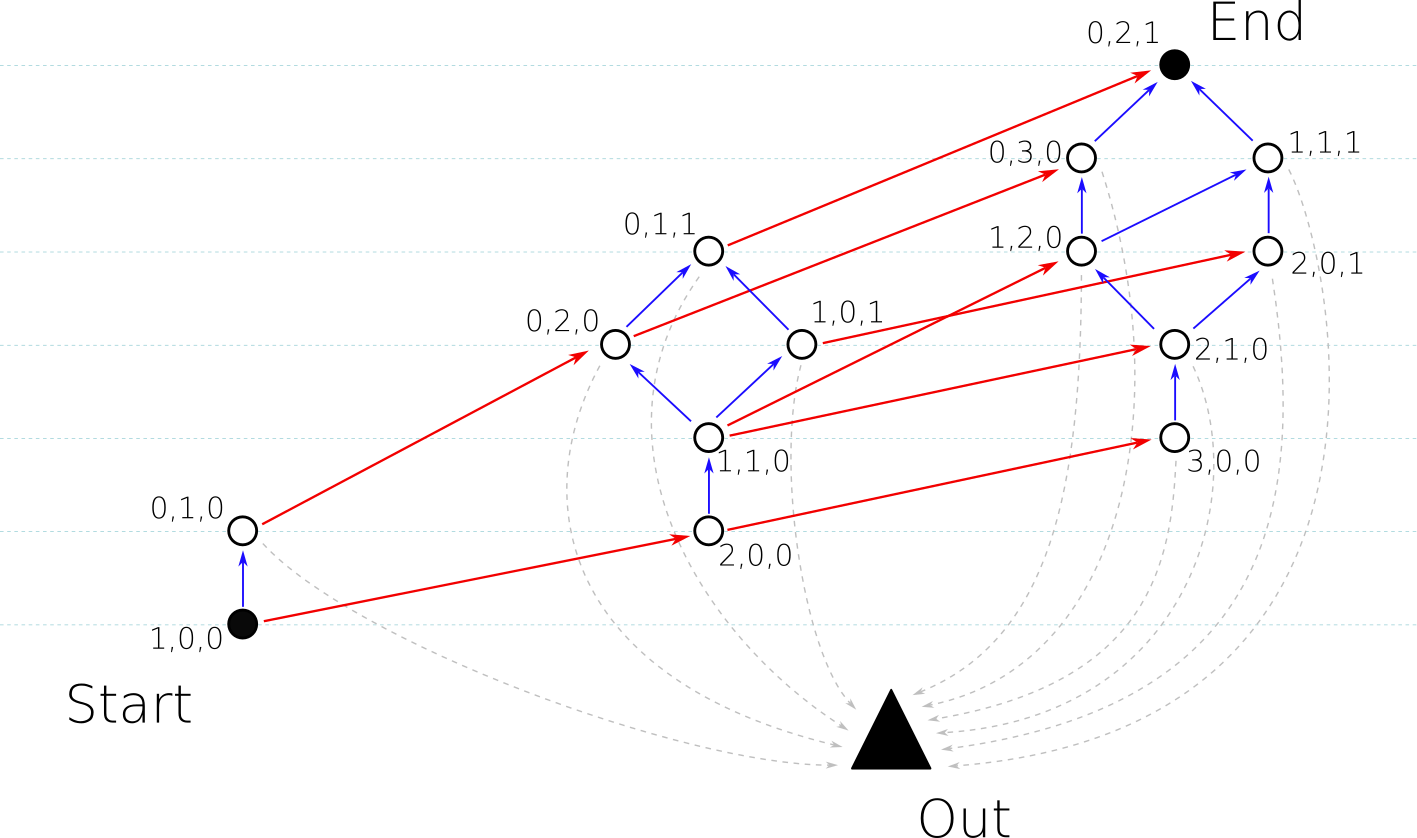

In [3]:
display(Image("Illustration_new.png", width=700))

In [4]:
N = 1000
d = 0.5 / N
pop = [2,2,3]

alpha = np.zeros(max(pop),dtype=int)
for ind in pop:
    alpha[ind - 1] += 1
alpha = list(alpha)

duplication rate d: 0.0005
P[End]: 0.0823112073112073


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.94it/s]


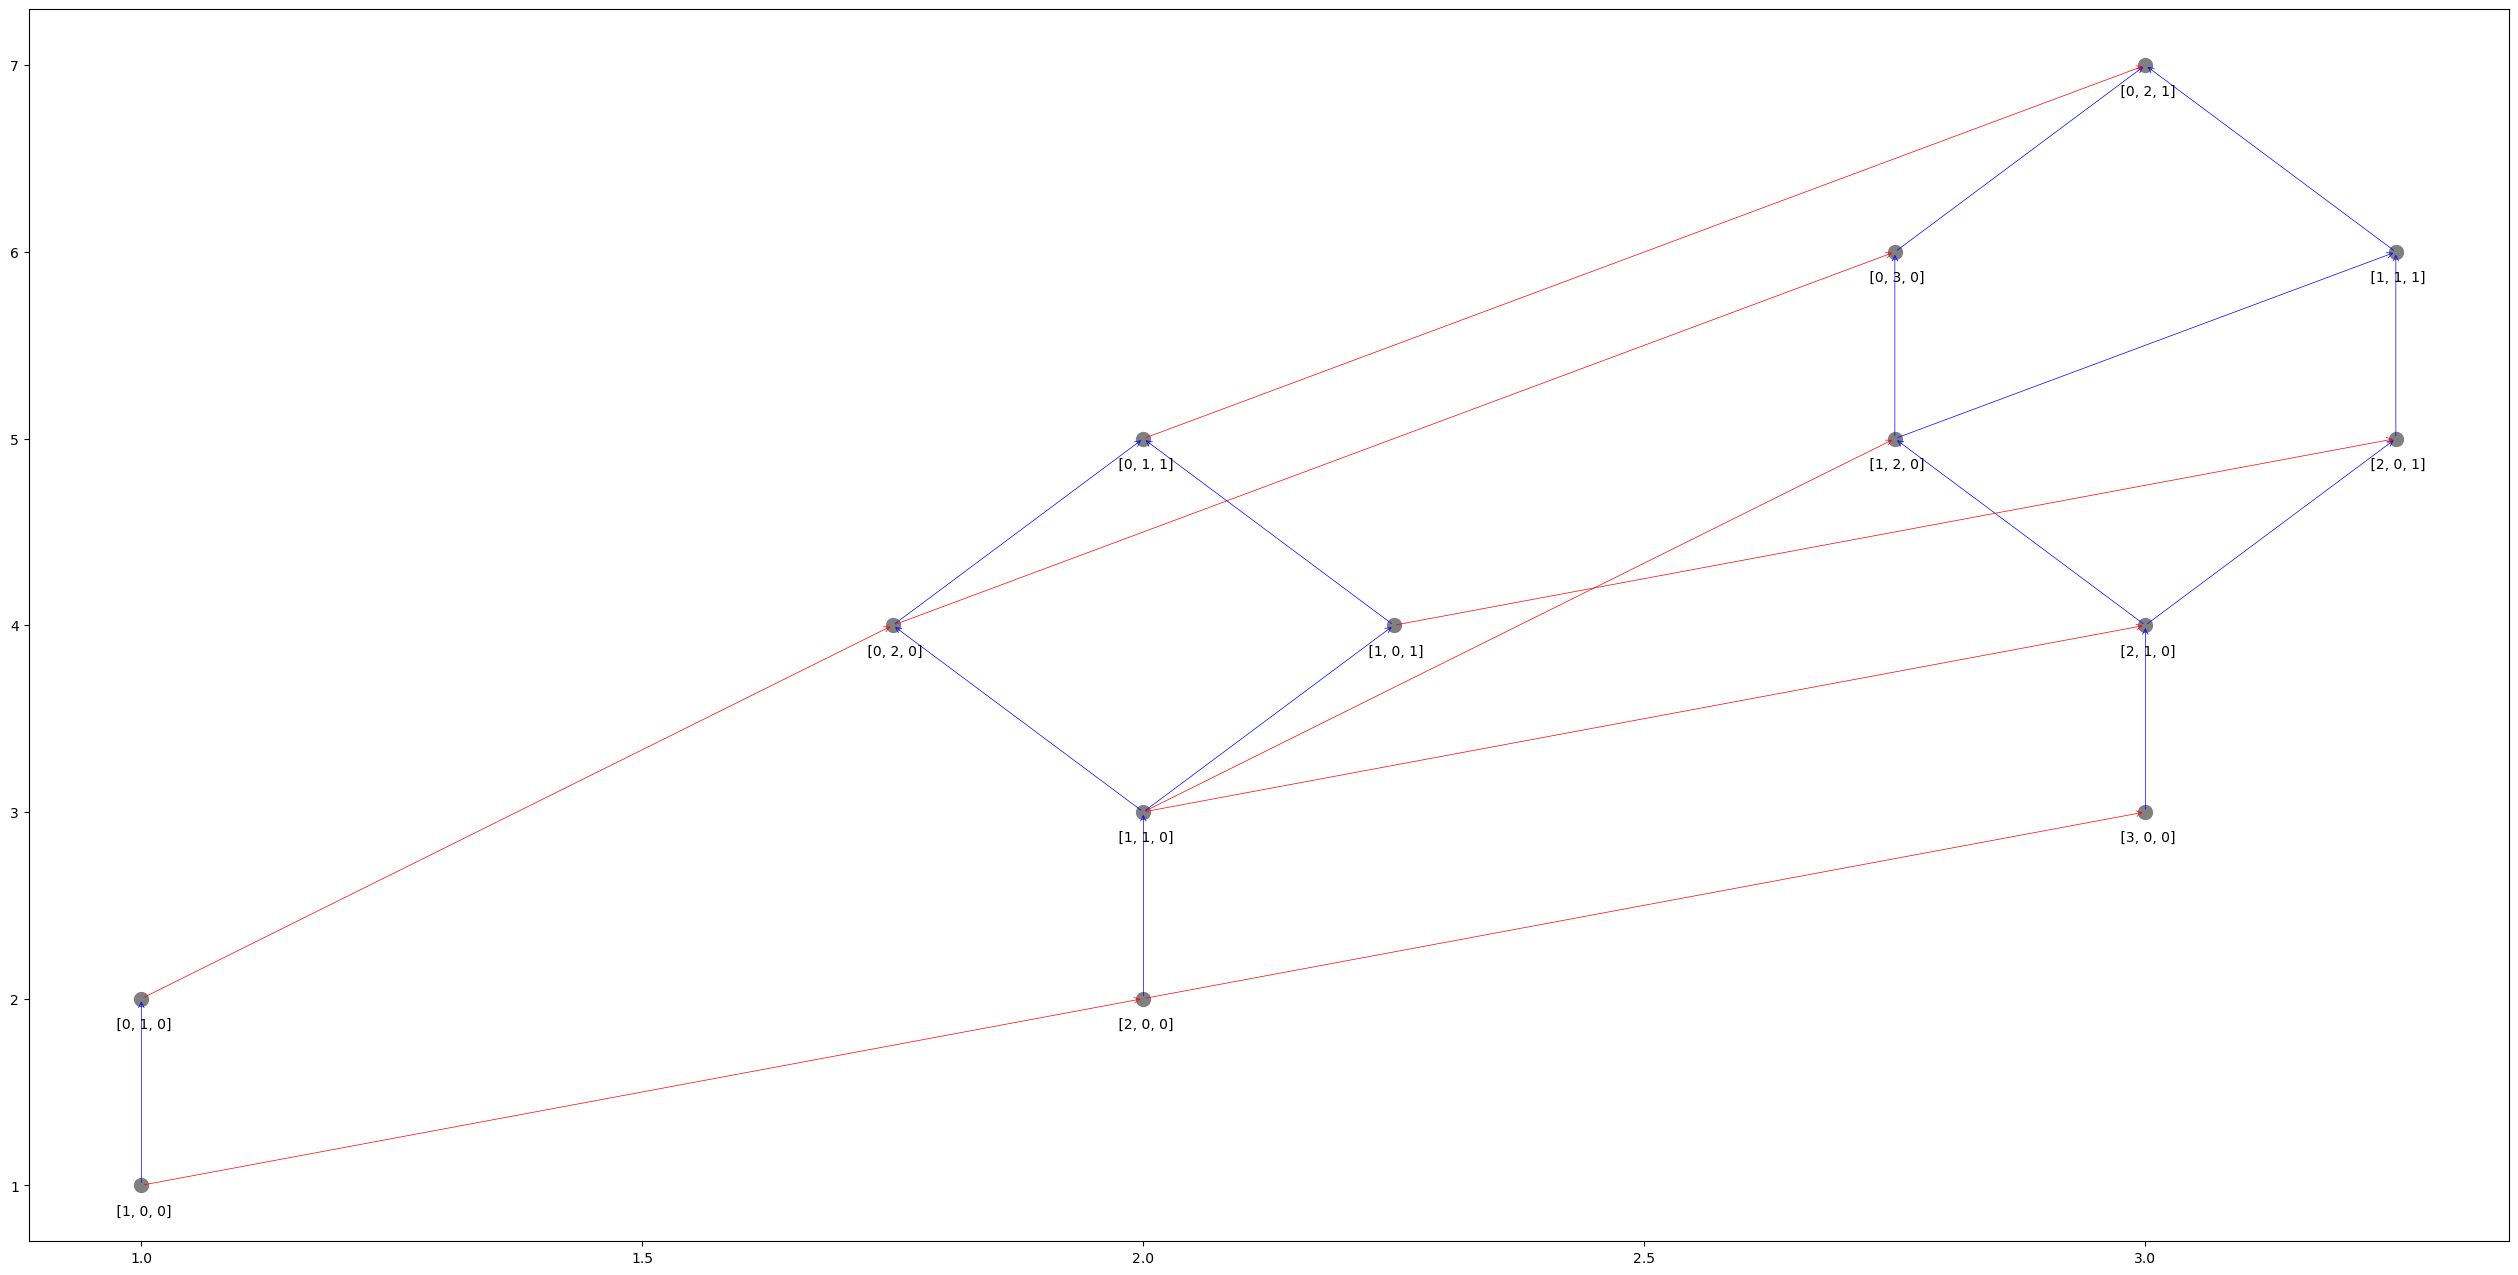

In [5]:
graph = make_graph(alpha, N, d)
print("duplication rate d:",d)
print("P[End]:",success_prob(graph, alpha)[0])
draw_graph(graph)

This probability depends on the ratio of $d$ and $1/N$ and $\alpha_{end}$. Therefore, for given $\alpha_{end}$ we can find the most likely $d$.

We consider three different samples of 10 individuals.

In the first case, we have 2 indivuals with 1 copy, 3 with two copies and 5 with three copies, leading to $$\alpha_{end} = [2,3,5]$$

Second, we consider 5 indivuduals with 2 copies and 5 individuals with 3 copies, i.e. $$\alpha_{end}=[0,5,5]$$

Third, all 10 individuals have three copies, so that $$\alpha_{end}=[0,0,10]$$


For all three cases, we calculate the probability to start in $\alpha_{start}=[1,]$ and to end in $\alpha_{end}$ before hitting $\alpha_{out}$ depending on $d$.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.06it/s]


[2, 3, 5] Most likely d: 0.0003940262626262626


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.02it/s]


[0, 5, 5] Most likely d: 0.00021221414141414142


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.45it/s]


[0, 0, 10] Most likely d: 9.10060606060606e-05


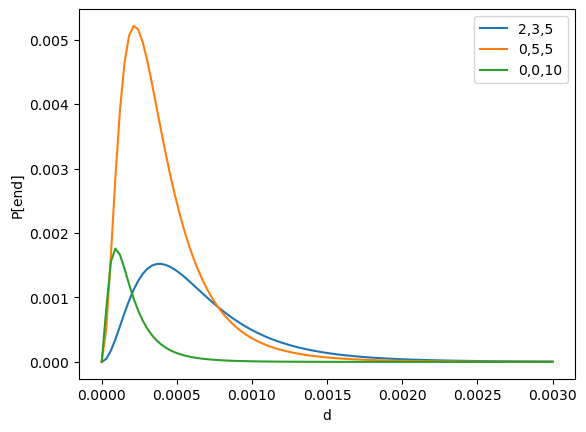

In [6]:
fig, ax = plt.subplots()

for my_label in [[2,3,5],[0,5,5],[0,0,10]]:
    N = 1000
    d_space = 1 / N  * np.linspace(0.0001,3,100)
    success = []
    for d in tqdm(d_space):
        graph = make_graph(my_label, N, d)
        success.append(success_prob(graph, my_label)[0])
    ax.plot(d_space,success)
    print(my_label, "Most likely d:", d_space[success.index(max(success))])
ax.legend(['2,3,5','0,5,5','0,0,10'])
plt.xlabel('d')
plt.ylabel('P[end]')

plt.show()

# Yule birth process

- We start with a standard coalescence tree (backward approach) of a sample of $n$ with constant population size $N$
- Then, we place duplication events on the tree with rate $d$ as in the standard mutation process and duplicate the subtree. Note, that since also the already duplicated lineages can duplicate again, the number of duplication events along an individual-branch is not Poisson distributed, but negative binomial distributed, as in the standard Yule birth process
- Last, we place mutations with rate $\mu$ on the whole tree and generate the genotype matrix

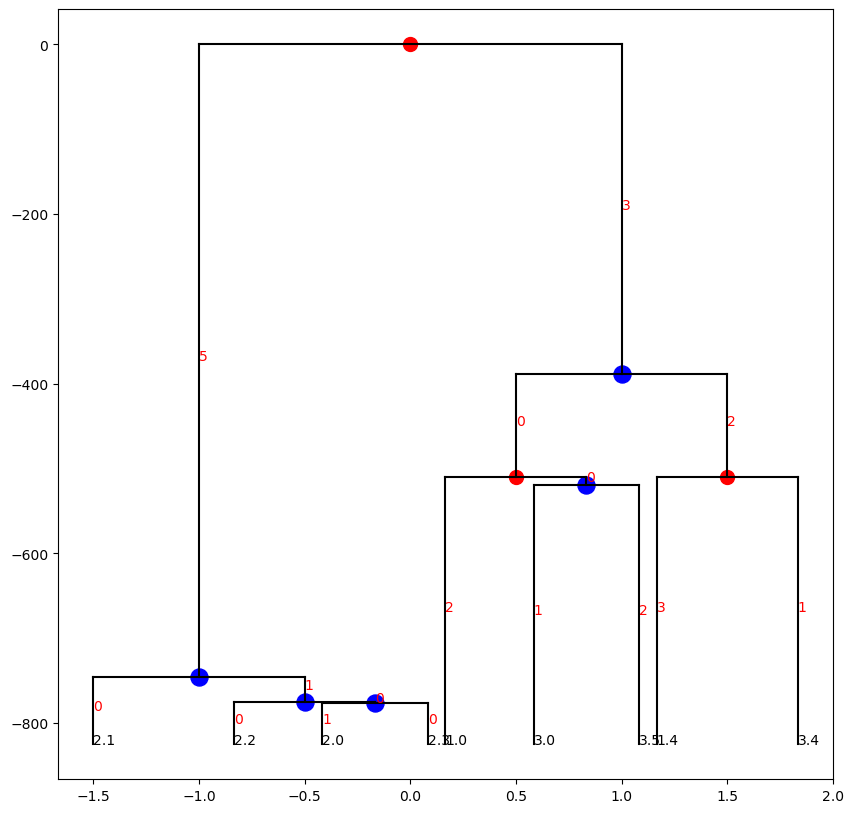

In [7]:
n = 3
N = 1000
d = 0.002
mu = 0.005

t = make_std_coal_tree(n,N)

make_duplications(t,d)
make_mutations(t,mu)
draw_png_tree(t)

This process does not cope ancient duplications.

For duplication process with rate $d$, we find that the number of duplication events along a time span of $T \sim Geo(\frac{1}{2N})$ is given by

$$ Z \sim Geo(e^{-dT})$$

Hence, we sum over $L$:

$$Prob_d[Z=k] = \sum_T \frac{1}{2N} \left(1-\frac{1}{2N}\right)^T (1-e^{-dT})^k e^{-dT}.$$

And multiply the probabilities over all individuals independently and take the maximum likelihood $d$.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.60it/s]


(0.0005152343434343434, 0.0006970464646464646)

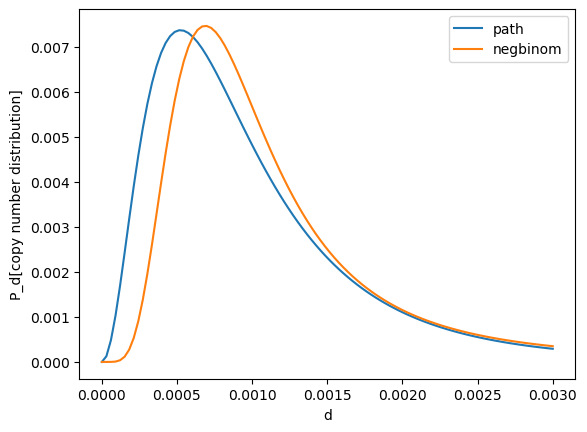

In [8]:
import numpy as np

def d_estimate(pop, N=1000, plot=False):

    d_space = 1 / N  * np.linspace(0.0001,3,100)
    log_p_negbinom = []
    p_path = []
    for d in tqdm(d_space):
        p = 1
        for k in pop:
            def summand(T):
                out = (1/(2*N)) * (1-(1/(2*N))**T)* (1-np.exp(-d*T))**k * np.exp(-d*T) 
                return out
            mysum = 0
            T = 1
            while (T<(3*N)):
                T += 1
                mysum += summand(T)

            result = mysum
            p += np.log(result)
        log_p_negbinom.append(p)
        
        graph = make_graph(pop, N, d)
        p_path.append(success_prob(graph, pop)[0])
        
    d_negbinom = d_space[log_p_negbinom.index(max(log_p_negbinom))]
    d_path = d_space[p_path.index(max(p_path))]

    if(plot):
        plt.plot(d_space,p_path)
        plt.plot(d_space,np.exp(log_p_negbinom))

        plt.legend(['path','negbinom'])
        plt.ylabel('P_d[copy number distribution]')
        plt.xlabel('d')
    return(d_path,d_negbinom)
    

pop = [2,2,3]
N = 1000
d_estimate(pop,N,plot=True)

## Structured Coalescence

Start with a present day sample of $n$ indivudals with a given copy number distribution. With rate $d$ an "de-duplication" event may happen, or with $1/N$ a coalescence event, if two individuals carry the same number of gene copies. We can also track the "path", i.e. the current gene duplication distribution along the tree.

Then, place mutations on the tree.

In [9]:
pop = [2,2,3]
N = 1000
d = d_estimate(pop, N)[0]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.98it/s]


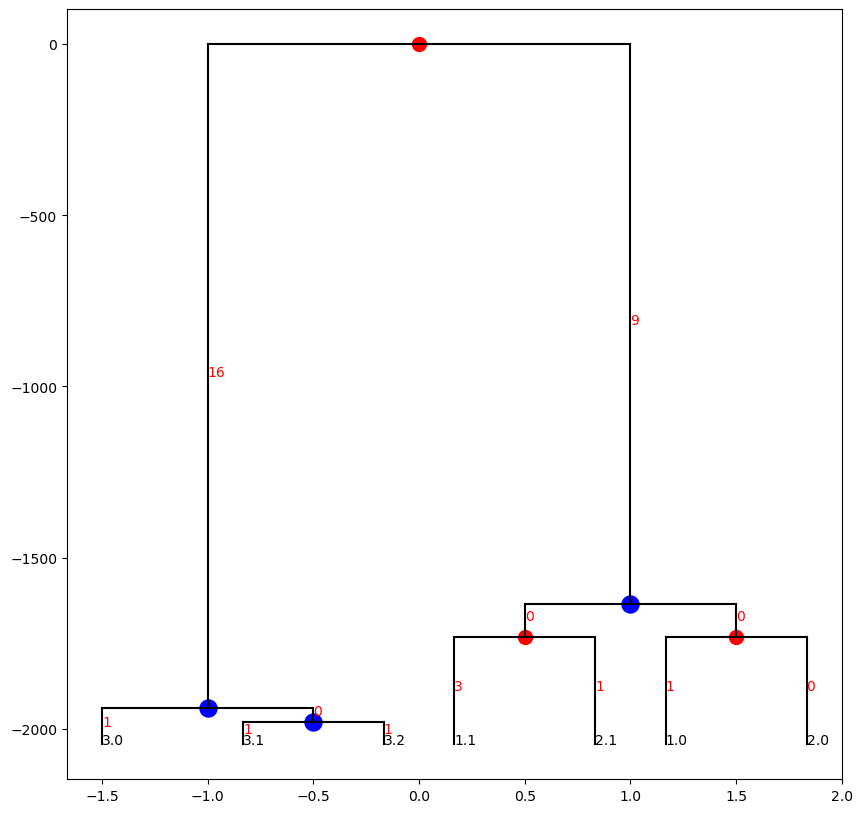

In [10]:
t, path = make_structured_coal_tree(pop,d,N)
make_mutations(t,mu)
draw_png_tree(t)

With this structured coalescent simulations, we can count and date the duplication events.